In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")


In [14]:
conn = engine.connect()

In [26]:
# reflect an existing database into a new model
s_data = pd.read_sql("SELECT * FROM station", conn)

# reflect the tables
s_data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [27]:
# reflect an existing database into a new model
m_data = pd.read_sql("SELECT * FROM measurement", conn)

# reflect the tables
m_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [18]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)

In [20]:
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
m_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [33]:
#with inspector
from sqlalchemy import inspect
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [35]:
#with session query dictionary
m_row = session.query(Measurement).first()
m_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ffca77c7b80>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [43]:
# Calculate the date one year from the last date in data set using dt subtract 365 days to find the date a year ago
first_date = dt.date(2017,8,23)
year_ago = first_date - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [44]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).filter(Measurement.prcp >= 0.0).all()

In [48]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp, columns=['Date', 'Precipitation'])
prcp_df = prcp_df.set_index('Date')
prcp_df.head(25)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


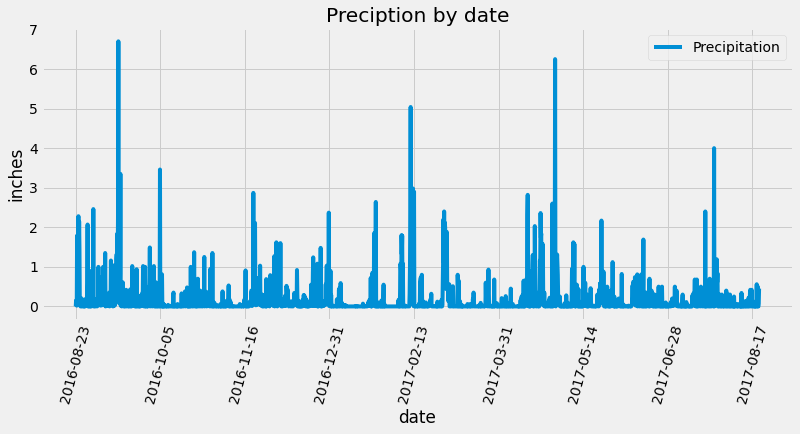

In [51]:
# Use Pandas Plotting with Matplotlib to plot the data

title = "Preciption by date"
y = "inches"
x = "date"
prcp_df.plot(title=title, ylabel=y, xlabel=x, figsize=(12,5), rot=75)
plt.show()





In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station.station).count()
num_stations

9

In [62]:
m_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [59]:
#using pandas
group_m_df = m_data.groupby('station').count()
group_m_df = group_m_df.sort_values(by=["id"],ascending=False)
group_m_df

,id,date,prcp,tobs
station,,,,
USC00519281,2772,2772,2772,2772
USC00519397,2724,2724,2685,2724
USC00513117,2709,2709,2696,2709
USC00519523,2669,2669,2572,2669
USC00516128,2612,2612,2484,2612
USC00514830,2202,2202,1937,2202
USC00511918,1979,1979,1932,1979
USC00517948,1372,1372,683,1372
USC00518838,511,511,342,511


In [60]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [61]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active

('USC00519281', 2772)

In [66]:
#calc high, low, avb
station_high = session.query(Measurement.station, Measurement.date, func.max(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
station_high

station_low = session.query(Measurement.station, Measurement.date, func.min(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
station_low

station_avg = session.query(Measurement.station, Measurement.date, func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
station_avg


('USC00519281', '2010-01-01', 71.66378066378067)

In [68]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
active_station_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == most_active[0]).\
    order_by(Measurement.date).all()
active_station_temps

temp_df = pd.DataFrame(active_station_temps, columns=['Date' , "Temps"])
temp_df

,Date,Temps
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


In [73]:
station_high[2]

85.0

In [72]:
station_low[2]

54.0

In [74]:
station_high[2] - station_low[2]

31.0

(array([ 6., 10., 15., 27., 41., 58., 72., 86., 29.,  8.]),
 array([59. , 61.4, 63.8, 66.2, 68.6, 71. , 73.4, 75.8, 78.2, 80.6, 83. ]),
 <BarContainer object of 10 artists>)

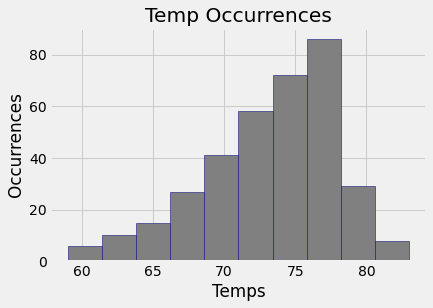

In [81]:
#and plot the results as a histogram
plt.title("Temp Occurrences")
plt.xlabel("Temps")
plt.ylabel("Occurrences")

plt.hist(temp_df['Temps'], bins=10, color="gray", edgecolor="navy")

# Close session

In [82]:
# Close Session
session.close()